In [1]:
from decode import *

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

#### It seems that, with AlphaMonarch model, the phenomenom is not obvious on the displayed cases.

In [2]:
query="A coin is heads up. Fletcher flips the coin. Conception flips the coin. Is the coin still heads up?"
template = """[INST]{question}[/INST]
               """

# k_response = get_k_path_prob(model, tokenizer, template.format(question=query), k=1)
k_response = get_k_path_prob_follow_up(model, tokenizer, template.format(question=query), k=5)

[('5', tensor(0.0957)), ('heads,', tensor(0.2377)), ('4', tensor(0.1666)), ('tails.', tensor(3.5910e-05)), ('', tensor(0.0006)), ('', tensor(0.0008)), ('"', tensor(0.0829)), ('"No', tensor(2.3499e-05)), ('"No,"', tensor(0.0001)), ('says', tensor(8.2030e-06)), ('Con', tensor(9.3868e-06)), ('Conception', tensor(2.2744e-05)), ('Conception.', tensor(0.0002)), ('', tensor(0.0002)), ('', tensor(0.0001)), ('"', tensor(0.0118)), ('"Yes', tensor(9.9870e-05)), ('"Yes,"', tensor(0.0007)), ('says', tensor(0.0003)), ('F', tensor(0.0005)), ('Flet', tensor(0.0006)), ('Fletcher', tensor(0.0016)), ('Fletcher.', tensor(0.0006)), ('', tensor(0.0020)), ('', tensor(0.0070)), ('"', tensor(0.6216)), ('"No', tensor(0.0002)), ('"No,"', tensor(0.0011)), ('says', tensor(0.0004)), ('Con', tensor(0.0005)), ('Conception', tensor(0.0007)), ('Conception.', tensor(0.0018)), ('', tensor(0.0007)), ('', tensor(0.0021)), ('"', tensor(0.2540)), ('"Yes', tensor(0.0005))]
--------------------
[('', tensor(0.0949)), ('', tens

In [1]:
# load model and tokenizer
from filter import *

tokenizer = AutoTokenizer.from_pretrained('Salesforce/SFR-Embedding-Mistral')
model = AutoModel.from_pretrained('Salesforce/SFR-Embedding-Mistral')
tokenizer.add_eos_token = True

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [29]:
def generate_synthetic_conversation(scenarios, customer_profiles, agent_profiles, model, num_samples):
    pass
customer_profiles = []
agent_profiles = []
num_samples = 0

### Scenario-Based Generation

In [27]:
# Scenario Based Generation
scenarios = [
    {
        "name": "RudeCustomer",
        "description": "Sales agent discuss insurance policy with a customer",
        "good_response": "Customer is rude.",
        "bad_response": "Customer is polite."
    },
]

conversations = generate_synthetic_conversation(scenarios, customer_profiles, agent_profiles, model, num_samples)

### Requirement: -- Customer should be Rude

In [ ]:
pset = ["Sale: Hello, how can I help with your insurance needs today? Customer: Not interested",
 "Sale: Hello, how can I help with your insurance needs today? Customer: I am interested, but I am not sure if I can afford it",
 "Sale: Hello, how can I help with your insurance needs today? Customer: What have you got?",
 "Sale: Hello, how can I help with your insurance needs today? Customer: Nah, I'll pass on that.",
 "Sale: Hello, how can I help with your insurance needs today? Customer: I've been thinking about getting insurance, what plans do you offer?",
 "Sale: Hello, how can I help with your insurance needs today? Customer: Sorry, I'm busy right now. Can't talk.",
 "Sale: Hello, how can I help with your insurance needs today? Customer: Sorry, I'm busy right now. Can't talk currently.",
 "Sale: Hello, how can I help with your insurance needs today? Customer: Sorry, I'm busy right now. Can't talk now.",
 "Sale: Hello, how can I help with your insurance needs today? Customer: Sorry, I'm busy right now. Can't talk right now.",]

In [3]:
max_length = 4096

# pset = ["Sale: Hello, how can I help with your insurance needs today? Customer: Not interested",
#         "Sale: Hello, how can I help with your insurance needs today? Customer: I am interested, but I am not sure if I can afford it",
#         "Sale: Hello, how can I help with your insurance needs today? Customer: What have you got?",
#         "Sale: Hello, how can I help with your insurance needs today? Customer: Nah, I'll pass on that.",
#         "Sale: Hello, how can I help with your insurance needs today? Customer: I've been thinking about getting insurance, what plans do you offer?",
#         "Sale: Hello, how can I help with your insurance needs today? Customer: Sorry, I'm busy right now. Can't talk.",
#         "Sale: Hello, how can I help with your insurance needs today? Customer: Sorry, I'm busy right now. Can't talk currently.",
#         "Sale: Hello, how can I help with your insurance needs today? Customer: Sorry, I'm busy right now. Can't talk now.",
#         "Sale: Hello, how can I help with your insurance needs today? Customer: Sorry, I'm busy right now. Can't talk right now.",
#         "Sale: Hello, how can I help with your insurance needs today? Customer: Sorry, I'm busy right now. Can not talk as of now.",
#         "Sale: Hello, how can I help with your insurance needs today? Customer: Yes, please. I am looking for life insurance plans.",
#         "Sale: Hello, how can I help with your insurance needs today? Customer: Insurance? No thanks, I don't believe in it.",
#         "Sale: Hello, how can I help with your insurance needs today? Customer: Not now, I'm watching a movie.",
#         "Sale: Hello, how can I help with your insurance needs today? Customer: That's great timing, I was just thinking about updating my insurance coverage.",
#         "Sale: Hello, how can I help with your insurance needs today? Customer: No, thanks. I'm good with my current plan.",
#         "Sale: Hello, how can I help with your insurance needs today? Customer: I'm just browsing, not really looking to buy anything."]

pset = ["Sale: Hello, how can I help with your insurance needs today? Customer: Not interested",
 "Sale: Hello, how can I help with your insurance needs today? Customer: I am interested, but I am not sure if I can afford it",
 "Sale: Hello, how can I help with your insurance needs today? Customer: What have you got?",
 "Sale: Hello, how can I help with your insurance needs today? Customer: Nah, I'll pass on that.",
 "Sale: Hello, how can I help with your insurance needs today? Customer: I've been thinking about getting insurance, what plans do you offer?",
 "Sale: Hello, how can I help with your insurance needs today? Customer: Sorry, I'm busy right now. Can't talk.",
 "Sale: Hello, how can I help with your insurance needs today? Customer: Sorry, I'm busy right now. Can't talk currently.",
 "Sale: Hello, how can I help with your insurance needs today? Customer: Sorry, I'm busy right now. Can't talk now.",
 "Sale: Hello, how can I help with your insurance needs today? Customer: Sorry, I'm busy right now. Can't talk right now.",]

batch_dict = tokenizer(pset, max_length=max_length-1, padding=True, truncation=True, return_tensors="pt")
outputs = model(**batch_dict)
embeddings = last_token_pool(outputs.last_hidden_state, batch_dict['attention_mask'])
# def sentence_embedder(sentences, tokenizer, max_length):
#     batch_dict = tokenizer(sentences, max_length=max_length-1, padding=True, truncation=True, return_tensors="pt")
#     outputs = model(**batch_dict)
#     embeddings = last_token_pool(outputs.last_hidden_state, batch_dict['attention_mask'])
#     return embeddings

# embeddings = sentence_embedder(conversations, tokenizer, max_length)

embeddings = F.normalize(embeddings, p=2, dim=1)
embeddings = embeddings.detach().numpy()

In [9]:
def plot_beautiful_embeddings(embeddings, title:str="Embedding PCA"):
    # Improve the aesthetics of the PCA scatter plot
    pca_result = PCA(n_components=2).fit_transform(embeddings)
    x = pca_result[:, 0]
    y = pca_result[:, 1]

    fig, ax = plt.subplots(figsize=(10, 8))  # Create a figure and an axes object
    scatter = ax.scatter(x, y, c=np.arange(len(embeddings)), cmap='viridis', alpha=0.6, edgecolors='w', s=80)
    ax.set_title(title, fontsize=18)
    ax.set_xlabel('Principal Component 1', fontsize=14)
    ax.set_ylabel('Principal Component 2', fontsize=14)
    fig.colorbar(scatter, ax=ax, label='Data Point Index')
    ax.grid(True)  # Add grid for better readability
    ax.axhline(0, color='black', linewidth=0.5)
    ax.axvline(0, color='black', linewidth=0.5)

    # Annotate the points with their index
    for i, txt in enumerate(range(len(embeddings))):
        ax.annotate(txt, (x[i], y[i]), textcoords="offset points", xytext=(0,10), ha='center')

    return fig  # Return the figure object

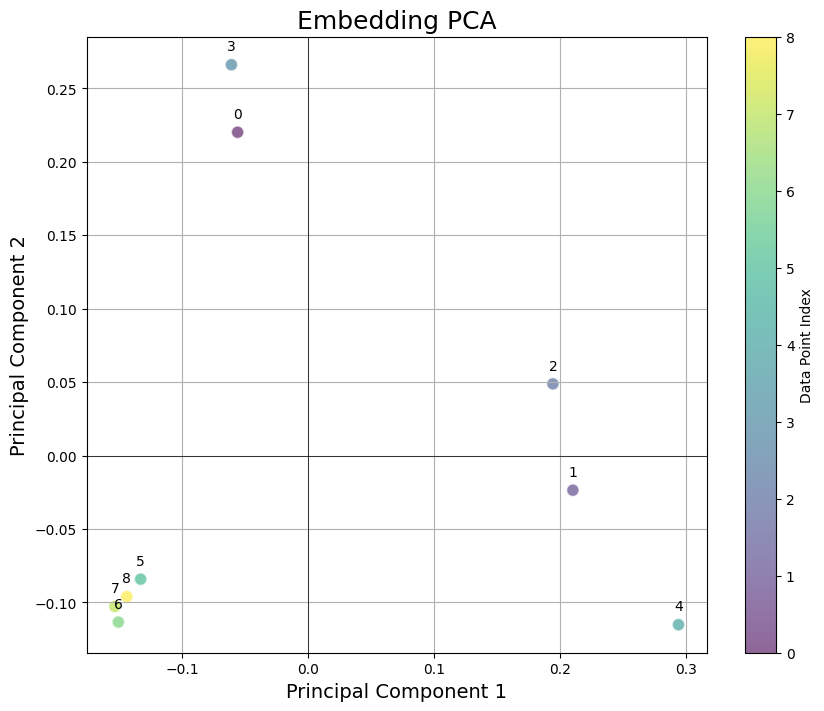

In [10]:
fig1 = plot_beautiful_embeddings(embeddings)

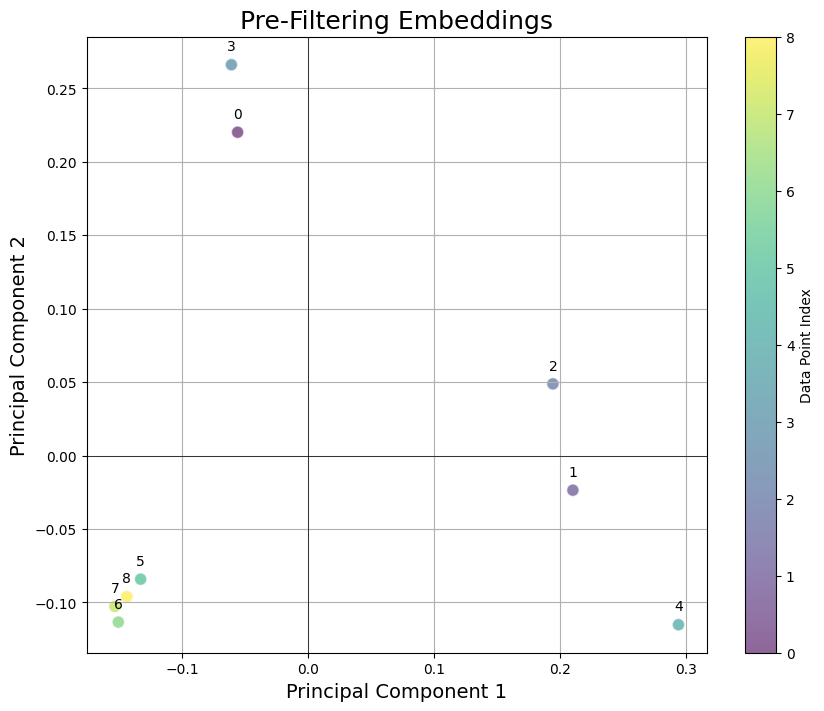

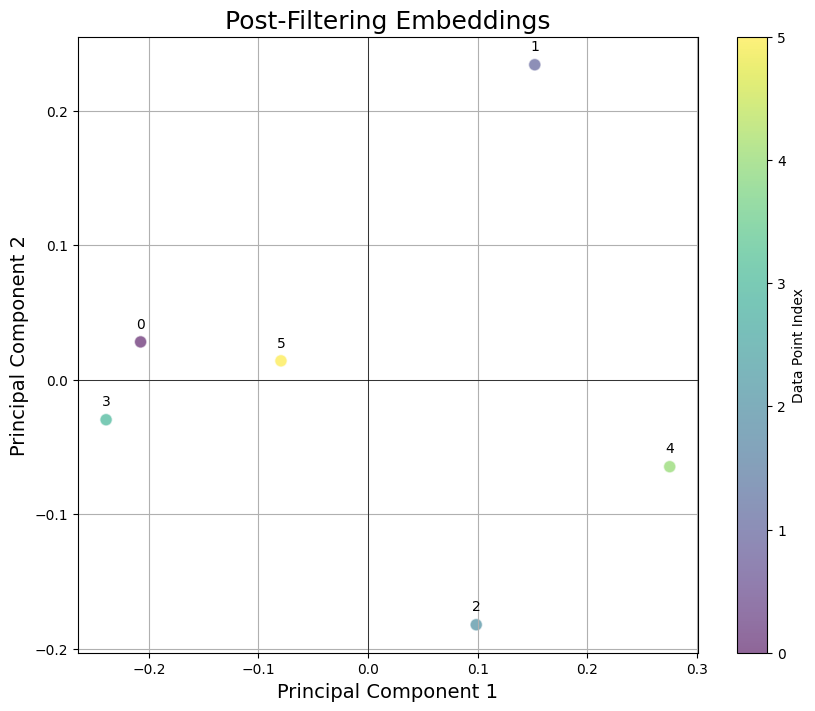

In [16]:
pre_filter_fig = plot_beautiful_embeddings(embeddings, title="Pre-Filtering Embeddings")
post_filter_fig = plot_beautiful_embeddings(filtered_embeddings, title="Post-Filtering Embeddings")
# # Plot the pre_filter_fig and post_filter_fig side by side in the same row
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))  # 1 row, 2 columns

# # Place pre_filter_fig on the first axis
# ax1.imshow(pre_filter_fig.canvas.tostring_rgb(), aspect='auto')
# ax1.axis('off')  # Hide the axis

# # Place post_filter_fig on the second axis
# ax2.imshow(post_filter_fig.canvas.tostring_rgb(), aspect='auto')
# ax2.axis('off')  # Hide the axis

# plt.tight_layout()
# plt.show()



In [21]:
# pre_filter_fig.savefig("pre_filter_fig.png")
# post_filter_fig.savefig("post_filter_fig.png")

from PIL import Image

# Load the images
pre_filter_img = Image.open("pre_filter_fig.png")
post_filter_img = Image.open("post_filter_fig.png")

# Concatenate the images side by side
combined_img = Image.new('RGB', (pre_filter_img.width + post_filter_img.width, pre_filter_img.height))
combined_img.paste(pre_filter_img, (0, 0))
combined_img.paste(post_filter_img, (pre_filter_img.width, 0))

# Display the combined image
combined_img.show()


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [13]:
filter = ClusterFilter(0.7)
filtered_indices, filtered_embeddings = filter.pick_k_per_cluster(embeddings, k=1)
# plot_embeddings(filtered_embeddings)

/Users/fangyuanyu/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


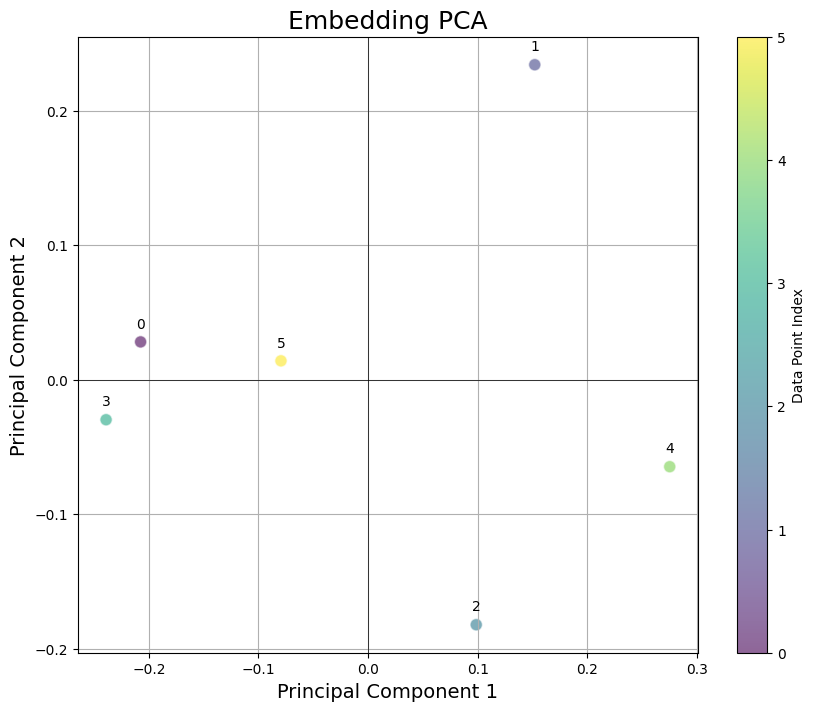

In [8]:
# filtered_indices
# np.allclose(embeddings[filtered_indices], filtered_embeddings)
plot_beautiful_embeddings(filtered_embeddings[:])

In [90]:
embeddings.shape[0]

13

In [85]:
filter = ClusterFilter(5, 0.8)
data = embeddings
filter.fit(data)
print('Pre-Filtering Dist: ', filter.get_avg_distance(data))
filtered_data = filter.filter(data)
print('Post-Filtering Dist: ', filter.get_avg_distance(filtered_data))


Pre-Filtering Dist:  0.16116153723888893
Post-Filtering Dist:  4.47314825180456e-09


/Users/fangyuanyu/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/fangyuanyu/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/fangyuanyu/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/fangyuanyu/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init

In [ ]:
filter.

In [101]:
class ClusterFilter:
    def __init__(self, ratio: float = 0.8):
        self.filter_ratio = ratio
        self.kmeans = None
        self.k = None

    def fit(self, data):
        if (self.k is not None and len(data) < self.k) or (self.k is None) or (self.kmeans is None):
            self.k = int(len(data) * self.filter_ratio)
            self.kmeans = KMeans(n_clusters=self.k, random_state=0)
        self.kmeans.fit(data)
        self.cluster_centers = self.kmeans.cluster_centers_
        self.inertia = self.kmeans.inertia_
        self.n_iter = self.kmeans.n_iter_
        self.labels = self.kmeans.labels_

    def get_avg_distance(self, data, threshold_ratio: float = None):
        self.fit(data)
        if threshold_ratio is not None:
            self.threshold_ratio = threshold_ratio
        cum_dist = 0
        cum_n = 0
        for i, label in enumerate(self.labels):
            center = self.cluster_centers[label]
            distance = np.linalg.norm(data[i] - center)
            cum_dist += distance
            cum_n += 1
        avg_dist = (cum_dist / cum_n)
        threshold_distance = avg_dist * 0.8
        return threshold_distance
    
    def pick_one_per_cluster(self, data):
        self.fit(data)
        filtered_data = []
        filtered_labels = []
        for i, label in enumerate(self.labels):
            if label not in filtered_labels:
                filtered_labels.append(label)
                filtered_data.append(data[i])
        return np.array(filtered_data)

    def filter(self, data, threshold_ratio: float = None):
        if threshold_ratio is not None:
            self.threshold_ratio = threshold_ratio
        threshold_distance = self.get_avg_distance(data)
        filtered_data = []
        for i, label in enumerate(self.labels):

            center = self.cluster_centers[label]
            distance = np.linalg.norm(data[i] - center)
            if distance < threshold_distance:
                filtered_data.append(data[i])
        return np.array(filtered_data)    


In [58]:
import numpy as np
from sklearn.cluster import KMeans

# Example data
data = np.array([[1, 2], [1, 4], [1, 0],
                 [10, 2], [10, 4], [10, 0]])

# Number of clusters
k = 2

# Applying KMeans
kmeans = KMeans(n_clusters=k, random_state=0).fit(data)
labels = kmeans.labels_
centers = kmeans.cluster_centers_

# Set a threshold distance
threshold_distance = 3

# Filter elements
filtered_elements = []
for i, label in enumerate(labels):
    center = centers[label]
    distance = np.linalg.norm(data[i] - center)
    if distance > threshold_distance:
        filtered_elements.append(data[i])

filtered_elements = np.array(filtered_elements)


/Users/fangyuanyu/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [67]:

cum_dist = 0
cum_n = 0
for i, label in enumerate(labels):
    center = centers[label]
    distance = np.linalg.norm(data[i] - center)
    cum_dist += distance
    cum_n += 1
avg_dist = (cum_dist / cum_n)
# I am going to filter out like 20% of the data anyway
threshold_distance = avg_dist * 0.8

# Filter elements
filtered_elements = []
for i, label in enumerate(labels):
    center = centers[label]
    distance = np.linalg.norm(data[i] - center)
    if distance > threshold_distance:
        filtered_elements.append(data[i])

filtered_elements = np.array(filtered_elements)

filtered_elements

kmeans = KMeans(n_clusters=k, random_state=0).fit(data)
labels = kmeans.labels_
centers = kmeans.cluster_centers_

centers


/Users/fangyuanyu/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


array([[10.,  2.],
       [ 1.,  2.]])

In [57]:
embeddings.shape

(13, 4096)

In [56]:
cosine_sim.shape

(56,)

In [54]:
kmeans

KMeans(n_clusters=3, random_state=0)

In [5]:
# Pick the high-energy solution here -- balance is important
# Solve the System, and use Toy Case to sell it



In [3]:
response = k_response[0][1:]
# [(r[0], r[1][0]) r for r in response]
response

[('heads,', tensor(0.2377)),
 ('4', tensor(0.1666)),
 ('tails.', tensor(3.5910e-05)),
 ('', tensor(0.0006)),
 ('', tensor(0.0008)),
 ('"', tensor(0.0829)),
 ('"No', tensor(2.3499e-05)),
 ('"No,"', tensor(0.0001)),
 ('says', tensor(8.2030e-06)),
 ('Con', tensor(9.3868e-06)),
 ('Conception', tensor(2.2744e-05)),
 ('Conception.', tensor(0.0002)),
 ('', tensor(0.0002)),
 ('', tensor(0.0001)),
 ('"', tensor(0.0118)),
 ('"Yes', tensor(9.9870e-05)),
 ('"Yes,"', tensor(0.0007)),
 ('says', tensor(0.0003)),
 ('F', tensor(0.0005)),
 ('Flet', tensor(0.0006)),
 ('Fletcher', tensor(0.0016)),
 ('Fletcher.', tensor(0.0006)),
 ('', tensor(0.0020)),
 ('', tensor(0.0070)),
 ('"', tensor(0.6216)),
 ('"No', tensor(0.0002)),
 ('"No,"', tensor(0.0011)),
 ('says', tensor(0.0004)),
 ('Con', tensor(0.0005)),
 ('Conception', tensor(0.0007)),
 ('Conception.', tensor(0.0018)),
 ('', tensor(0.0007)),
 ('', tensor(0.0021)),
 ('"', tensor(0.2540)),
 ('"Yes', tensor(0.0005))]

In [18]:
[tuple([r[0].split('.</s>')[0], np.round(r[1].item(), 3)]) for r in response]

[('There', 0.005),
 ('is', 0.025),
 ('no', 0.965),
 ('certainty', 0.25),
 ('about', 0.015),
 ('the', 0.002),
 ('coin', 0.0),
 ('still', 0.0),
 ('being', 0.0),
 ('heads', 0.011),
 ('up', 0.001),
 ('after', 0.0),
 ('both', 0.092),
 ('flips', 0.072)]

#### Toy preference dataset

In [3]:
Pset = ["Sale: Hello, how can I help with your insurance needs today? Customer: Not interested",
        "Sale: Hello, how can I help with your insurance needs today? Customer: I am interested, but I am not sure if I can afford it",
        "Sale: Hello, how can I help with your insurance needs today? Customer: What have you got?",
        "Sale: Hello, how can I help with your insurance needs today? Customer: Nah, I'll pass on that.",
        "Sale: Hello, how can I help with your insurance needs today? Customer: I do not need insurance, I am a robot",
        "Sale: Hello, how can I help with your insurance needs today? Customer: I've been thinking about getting insurance, what plans do you offer?",
        "Sale: Hello, how can I help with your insurance needs today? Customer: Sorry, I'm busy right now. Can't talk.",
        "Sale: Hello, how can I help with your insurance needs today? Customer: Yes, please. I am looking for life insurance plans.",
        "Sale: Hello, how can I help with your insurance needs today? Customer: Insurance? No thanks, I don't believe in it.",
        "Sale: Hello, how can I help with your insurance needs today? Customer: Not now, I'm watching a movie.",
        "Sale: Hello, how can I help with your insurance needs today? Customer: That's great timing, I was just thinking about updating my insurance coverage.",
        "Sale: Hello, how can I help with your insurance needs today? Customer: No, thanks. I'm good with my current plan.",
        "Sale: Hello, how can I help with your insurance needs today? Customer: I'm just browsing, not really looking to buy anything."]


# Diversity Filtering with Clustering Techniques


In [2]:
# Turn that open-sourced LLM into a reward model (!)

# Toy exmample of human preference dataset: (Prefer red stuff over blue stuff, this preference shall be hidden, and never explicitly stated)
# preference dataset
Pset = [("Red Apple", "Blue Apple"), 
        ("Lava", "Sea"),
        ("Blood", "Sky"),
        ("Strawberry", "Blueberry"),
        ("Red Dragon", "Blue Dragon"),
        ("Red Wine", "Ocean"),
        ("Manchester United", "Chelsea")]


format_preference_pair = lambda x: f"{x[0]} > {x[1]}"
form_preference = lambda Pset, indices = range(len(Pset)): ('\n').join(['-'+format_preference_pair(Pset[i]) for i in indices])
preferences = form_preference(Pset, [0, 1, 2, 3, 4])


1. Directly Feed the preference information to the whatever Monarch 7B model (which verylikely overfit on the validation set), and the model does NOT get the basic preference through demonstration. This will at least make the prompt optimisation difficult. 

2. The problem is always on whether we can train the RM, and not about whether it solves itself from the start

In [7]:
# model
# In the deepmind paper, the embedder is token out and re-train on a classifier, I will try to do decoding trick with it


# Model looks at the preference dataset and tries to learn the preference, and then use that to generate a reward model

template = """[INST] Here is a recording of a person's preference on a few items. 
{preferences}
Do you think this person would prefer {item1} over {item2}? Answers with yes, no, or unsure.[/INST]
           """
train_indices = [0,1,2,3,4]
test_index = 5
preferences = form_preference(Pset, train_indices)
query = template.format(preferences=preferences, item1=Pset[test_index][0], item2=Pset[test_index][1])

prob_yes = check_response_prob(model, tokenizer, query, target_response="yes")
prob_no = check_response_prob(model, tokenizer, query, target_response="no")

# normalized answer
norm_yes, norm_no = prob_yes / (prob_yes + prob_no), prob_no / (prob_yes + prob_no)
norm_yes, norm_no


(tensor(0.8487), tensor(0.1513))

In [4]:
inputs = tokenizer([query], return_tensors="pt")
gen_out = model.generate(**inputs, output_scores=True, return_dict_in_generate=True, max_new_tokens=20, pad_token_id=tokenizer.eos_token_id)
tokenizer.batch_decode(gen_out['sequences'], skip_special_tokens=True)

["[INST] Here is a recording of a person's preference on a few items. \n-Red Apple > Blue Apple\n-Lava > Sea\n-Blood > Sky\n-Strawberry > Blueberry\n-Red Dragon > Blue Dragon\nDo you think this person would prefer Red Wine over Ocean? Answers with yes, no, or unsure.[/INST]\n           \n[ASST] Based on the given preferences, it is unclear whether the person would prefer"]

In [1]:
# Then these are the preference score of the pair of items
norm_yes, norm_no
# So, the most naive way is to just use the current model to generate a preference score, and then fit that to the annotator with a linear matrix
# or, we would directly fine-tune the model on the preference dataset (which is not a good idea, because the model is very likely to overfit on the preference dataset)
# ok, but we can augment the preference dataset through prompt optimisation, and then fine-tune the model on the augmented dataset (such dataset could also be filtered to enhance diversity)




NameError: name 'norm_yes' is not defined